In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
import sys
import seaborn as sns

# Try to get the script directory; if in a notebook, use the current working directory
try:
    SCRIPT_DIR = Path(__file__).resolve().parent
except NameError:
    # We are in a notebook/interactive session
    SCRIPT_DIR = Path(os.getcwd()).resolve()

# Adjust this based on where your 'logs' folder is relative to the notebook
# If 'logs' is in the same folder as your notebook, use SCRIPT_DIR
# If 'logs' is one level up, use SCRIPT_DIR.parent
PROJECT_ROOT = SCRIPT_DIR.parent

LOG_FILE = PROJECT_ROOT / "logs" / "param_sweep_log.csv"
PLOT_DIR = PROJECT_ROOT / "logs" / "plots"

print(f"Looking for log file at: {LOG_FILE}")

def load_data(LOG_FILE):
    if not os.path.exists(LOG_FILE):
        print(f"Error: Log file not found at {LOG_FILE}")
        sys.exit(1)

    try:
        df = pd.read_csv(LOG_FILE)
        # Clean column names (remove spaces)
        df.columns = df.columns.str.strip()
        return df
    except Exception as e:
        print(f"Error reading CSV: {e}")
        sys.exit(1)


Looking for log file at: /Users/nautilus/gridfw/logs/param_sweep_log.csv


In [77]:
df = load_data(LOG_FILE=LOG_FILE)
# 1. Normalize the Metric (Relative Error)
df['Relative Error (%)'] = (1 - df['Ratio']) * 100

/var/folders/7c/q9_nslk55p94jf29j5gtcsxc0000gn/T/ipykernel_27520/2493094295.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


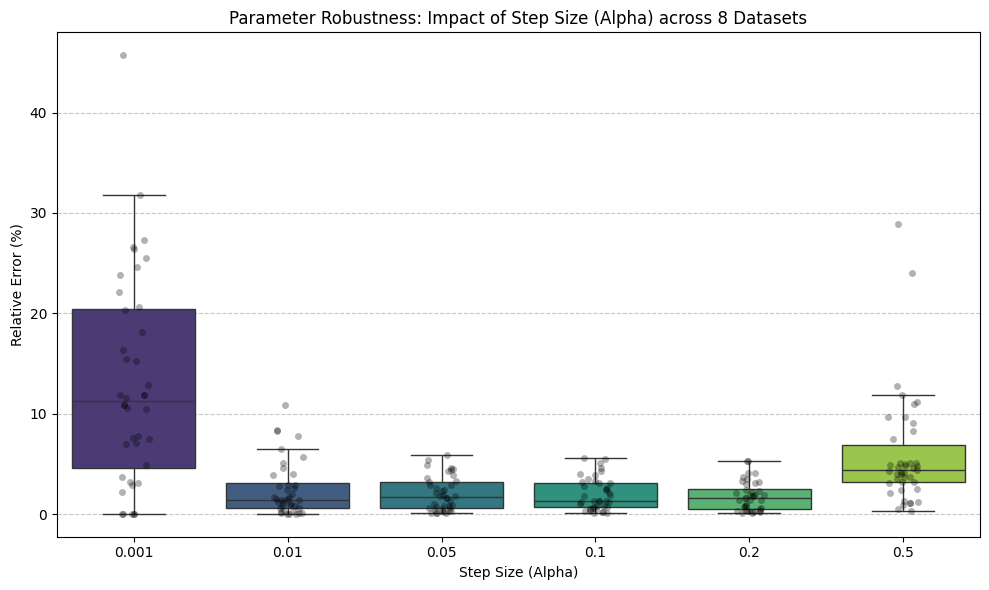

In [78]:
def plot_box_all_datasets_error():
    plt.figure(figsize=(10, 6))

    # 2. Create the Box Plot
    # This groups all 8 datasets together for each Alpha
    sns.boxplot(
        x="Alpha", 
        y="Relative Error (%)", 
        data=df, 
        palette="viridis", 
        showfliers=False # Hide extreme outliers to keep the scale readable
    )

    # 3. Overlay the actual data points (jitter)
    # This shows the reader that you have 8 real data points per box
    sns.stripplot(x="Alpha", y="Relative Error (%)", data=df, color='black', alpha=0.3, jitter=True)

    plt.title("Parameter Robustness: Impact of Step Size (Alpha) across 8 Datasets")
    plt.ylabel("Relative Error (%)")
    plt.xlabel("Step Size (Alpha)")
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # 5. Save and Show
    save_path = PROJECT_ROOT / "logs" / "plots" / f"box_all_data_errors.pdf"
    save_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(save_path, dpi=300)
    plt.show()

    
plot_box_all_datasets_error()

In [79]:
def plot_heat_all_alpha_error():
    # Create a Grid of Heatmaps (4 rows x 2 columns)
    g = sns.FacetGrid(df, col="Dataset", col_wrap=4, height=3, aspect=1.2, sharey=False)
    def draw_heatmap(data, **kwargs):
        # USE pivot_table INSTEAD OF pivot
        # 'aggfunc="mean"' fixes the duplicate error by averaging duplicates
        pivot = data.pivot_table(
            index="Alpha", 
            columns="Samples", 
            values="Relative Error (%)", 
            aggfunc="mean"
        )
        
        # Draw heatmap
        sns.heatmap(pivot, annot=False, cmap="Reds", cbar=False)
    # Map the heatmap function to the grid
    g.map_dataframe(draw_heatmap)

    # Add labels
    g.set_axis_labels("Samples (m)", "Alpha")
    g.set_titles(col_template="{col_name}")

    # Invert Y axis for all plots so small Alpha is at bottom
    for ax in g.axes.flat:
        ax.invert_yaxis()

    plt.subplots_adjust(top=0.9)
    g.figure.suptitle('Sensitivity Analysis across All Datasets (Relative Error %)')
    plt.show()

In [80]:


def plot_box_one_datasets_error(dataset_name):
    # 1. Filter data ONCE so both plots use the same subset
    subset = df[df['Dataset'] == dataset_name].copy()
    
    if subset.empty:
        print(f"Skipping {dataset_name} (No data)")
        return

    # Create figure with a good aspect ratio for grid placement
    plt.figure(figsize=(10, 6))

    # 2. Create the Box Plot (Thicker lines for PDF visibility)
    sns.boxplot(
        x="Alpha", 
        y="Relative Error (%)", 
        data=subset,  # <--- FIXED: Use subset, not df
        palette="viridis", 
        showfliers=False,
        linewidth=1.5 
    )

    # 3. Overlay the actual data points (jitter)
    # FIXED: Changed 'data=df' to 'data=subset' so we only see THIS dataset's points
    sns.stripplot(
        x="Alpha", 
        y="Relative Error (%)", 
        data=subset, # <--- FIXED
        color='black', 
        alpha=0.3, 
        jitter=True
    )

    # 4. Thesis Styling (Bigger fonts, No title)
    # We remove plt.title() because the LaTeX caption acts as the title
    plt.ylabel("Relative Error (%)", fontsize=14, fontweight='bold')
    plt.xlabel("Step Size (Alpha)", fontsize=14, fontweight='bold')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()

    # 5. Save and Close
    # Using pathlib / operator as in your snippet
    save_path = PROJECT_ROOT / "logs" / "plots"/ "box_alpha_errors" / f"box_{dataset_name}_data_errors.pdf"
    
    save_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    # Close the plot to free memory (crucial when looping)
    plt.close()
    print(f"Saved: {save_path.name}")

# --- Run the Loop ---
for dataset_name in df["Dataset"].unique():
    plot_box_one_datasets_error(dataset_name)

/var/folders/7c/q9_nslk55p94jf29j5gtcsxc0000gn/T/ipykernel_27520/4006469497.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/7c/q9_nslk55p94jf29j5gtcsxc0000gn/T/ipykernel_27520/4006469497.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/7c/q9_nslk55p94jf29j5gtcsxc0000gn/T/ipykernel_27520/4006469497.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


Saved: box_Residential_data_errors.pdf
Saved: box_Synthetic_high_corr_data_errors.pdf
Saved: box_Mnist_data_errors.pdf


/var/folders/7c/q9_nslk55p94jf29j5gtcsxc0000gn/T/ipykernel_27520/4006469497.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/7c/q9_nslk55p94jf29j5gtcsxc0000gn/T/ipykernel_27520/4006469497.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/7c/q9_nslk55p94jf29j5gtcsxc0000gn/T/ipykernel_27520/4006469497.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


Saved: box_Madelon_data_errors.pdf
Saved: box_Synthetic_toeplitz_data_errors.pdf
Saved: box_Secom_data_errors.pdf


/var/folders/7c/q9_nslk55p94jf29j5gtcsxc0000gn/T/ipykernel_27520/4006469497.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


Saved: box_Arrhythmia_data_errors.pdf
Saved: box_Myocardial_data_errors.pdf


/var/folders/7c/q9_nslk55p94jf29j5gtcsxc0000gn/T/ipykernel_27520/4006469497.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


In [81]:
def plot_one_dataset_heatmap_alpha_m_error(df, dataset_name):
    """
    Generates a side-by-side Heatmap (Error vs Time) for a specific dataset.
    """
    # Filter data for this specific dataset
    subset = df[df['Dataset'] == dataset_name].copy()
    
    if subset.empty:
        print(f"⚠️ Warning: No data found for dataset '{dataset_name}'")
        return

    # Calculate Relative Error % (100 - Ratio*100)
    subset['Relative Error (%)'] = (1 - subset['Ratio']) * 100

    # Setup the figure (Side-by-Side)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # --- PLOT A: ACCURACY (Relative Error) ---
    # Use pivot_table with aggfunc='mean' to handle duplicate runs safely
    piv_acc = subset.pivot_table(index="Alpha", columns="Samples", values="Relative Error (%)", aggfunc="mean")
    sns.heatmap(piv_acc, annot=True, fmt=".1f", cmap="Reds", ax=axes[0], cbar_kws={'label': 'Relative Error (%)'})
    axes[0].set_title(f"{dataset_name}: Optimization Error (Lower is Better)")
    axes[0].invert_yaxis() # Put small alpha at the bottom

    # --- PLOT B: EFFICIENCY (Runtime) ---
    piv_time = subset.pivot_table(index="Alpha", columns="Samples", values="FW_Time_s", aggfunc="mean")
    sns.heatmap(piv_time, annot=True, fmt=".2f", cmap="Blues", ax=axes[1], cbar_kws={'label': 'Runtime (s)'})
    axes[1].set_title(f"{dataset_name}: Runtime (Seconds)")
    axes[1].invert_yaxis()

    plt.tight_layout()
        # 5. Save and Show
    save_path = PROJECT_ROOT / "logs" / "plots"/ "heatmap_alpha_m_errors" / f"heat_{dataset_name}_data_errors.pdf"
    save_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(save_path, dpi=300)
    plt.show()

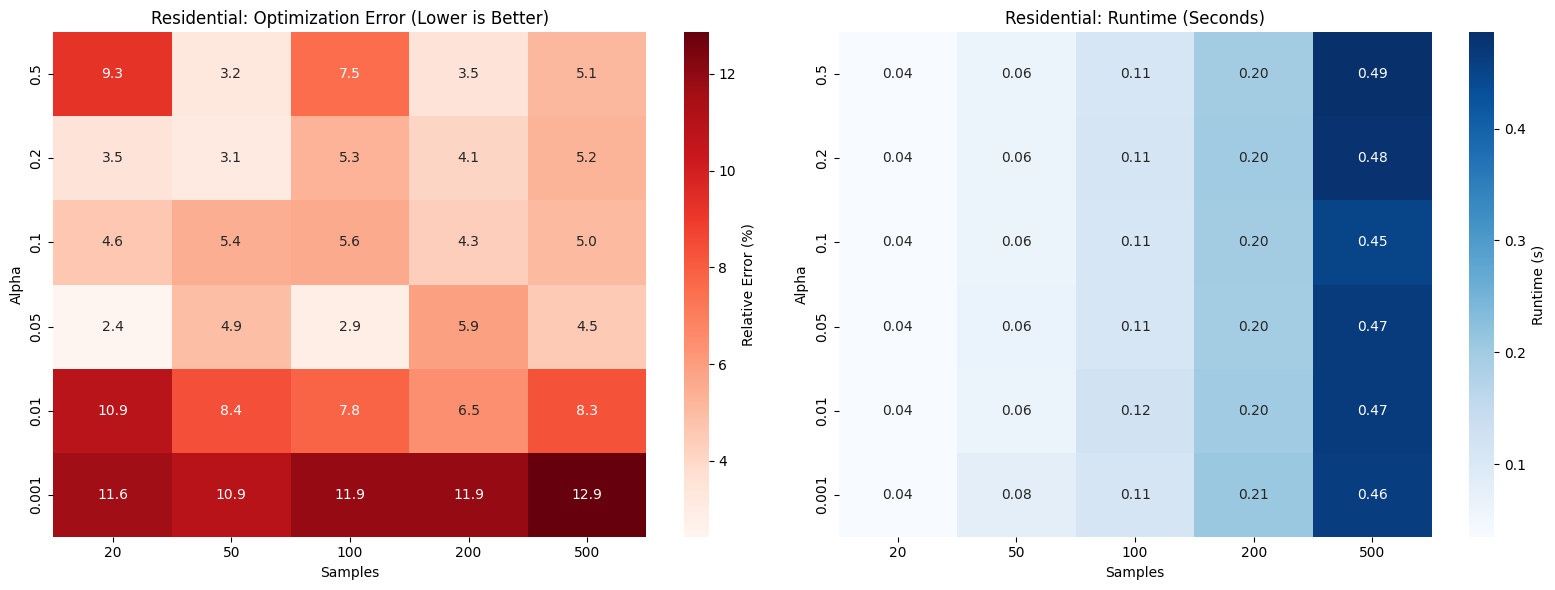

In [82]:
plot_one_dataset_heatmap_alpha_m_error(df, "Residential")
# Plot all
# for dataset_name in df["Dataset"].unique():
#     plot_one_dataset_heatmap_alpha_m_error(df, dataset_name)